In [1]:
import os, sys

os.chdir('e:\Downloads (E)\@Books\@TPM\@PDPC\@data_analysis\model_build')
sys.path.append('e:\Downloads (E)\@Books\@TPM\@PDPC\@data_analysis\model_build')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import matplotlib.ticker as ticker  ## special scaling stuff
import cmasher as cmr
import colorcet as cet
from importlib import reload  ## for reloading packages
import pickle
import OFM_postprocess_scripts as post
from importlib import reload

from matplotlib.ticker import AutoMinorLocator

In [2]:
# retrieve files from saved pickles
model_vers = 'v5'
exps_batchname = 'Policies and Indirect'
exps_filename = f'model{model_vers}_exps_{exps_batchname}_'
exps_s = post.read_experiments_from_pickle(f'data_output/{exps_filename}.pickleobject')
# extract relevant meta-information from pickled experiment object
meta_s = pd.DataFrame.from_dict(exps_s.results_metadata, orient='index')
meta_s['p_FlightBans'] = meta_s['p_FlightBans'].fillna(value=500).astype(int)
meta_s['p_FlightBans_nom'] = meta_s['p_FlightBans'] - exps_s.c_nominal_ref_date
results_s: pd.DataFrame = post.add_extra_metrics(exps_s)

# invert the policy inputs to be relative again (instead of machine-focused)
policy_inputs = dict((v, k) for k, v in exps_s.p_flightbans_map.items())  # inversion process
exps_s.results_verbose = exps_s.results_postprocess = None

## what do I want to do?
for rq1 (without indirect and R) get the difference in days (probably easier to do a different set of experiments)
do figure for difference in timing?
maybe graph in heatmap?

for rq2
make separate graph/heatmap for different R and indirect scenarios
how to show that R has a larger effect? would the heatmap already show that?
could probably drop the effect of direct importation?
need to do searchsort for 10k cases?

In [3]:
daysearch_piv = results_s.pivot(
    values='cum_infected',
    index='elapsed_nominal',
    columns='exp_id',
    )
meta_s['days_10k_cumulative'] = daysearch_piv.apply(np.searchsorted, axis=0, v=10000, side='left') - exps_s.c_nominal_ref_date



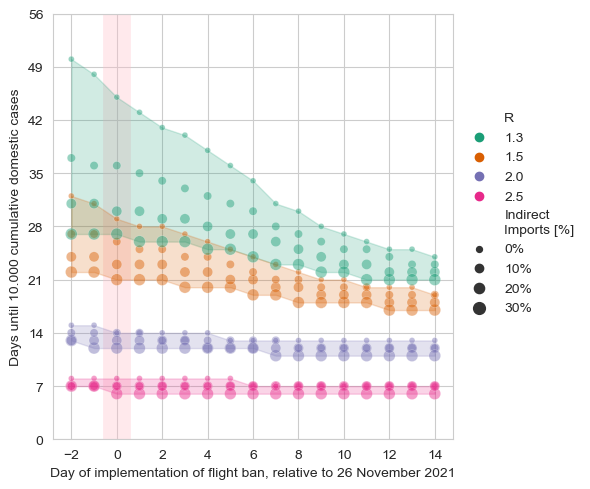

In [9]:
### ScatterPlot creation for RQ2
fig, ax = plt.subplots(figsize=(6,5))
Rzero_order = [1.3, 1.5, 2.0, 2.5]
## Section for only specific R numbers and sort for descending Rzero to try and plot the higher R numbers earlier (not useful)
plot_data = meta_s[meta_s['u_Rzero'].isin(Rzero_order)].sort_values(by='u_Rzero', ascending=False)
palette = 'Dark2'
sns.lineplot(data=plot_data,
             hue='u_Rzero',
             y='days_10k_cumulative',
             x='p_FlightBans_nom',
             # size='u_ImportsIndirect',
             alpha=0.,
             legend=False,
             palette=palette,
             errorbar=('pi', 100),
             ax=ax)

sns.scatterplot(data=plot_data,
                hue='u_Rzero',
                y='days_10k_cumulative',
                size='u_ImportsIndirect',
                x='p_FlightBans_nom',
                alpha=0.45,
                legend='full',
                palette=palette,
                ax=ax)

## Modify plot legend
h,_ = ax.get_legend_handles_labels()

l = ['R','1.3','1.5','2.0','2.5', 'Indirect\nImports [%]', '0%', '10%', '20%', '30%']
ax.legend(handles=h, labels=l, loc='upper left',bbox_to_anchor=(1,0.8),frameon=False)
# loc sets anchor, bbox_to_anchor sets location from anchor, frameon eliminates the legend frame

## Additional tweaks
ax.set_ylabel("Days until 10.000 cumulative domestic cases")
ax.set_xlabel("Day of implementation of flight ban, relative to 26 November 2021")
# ax.set_title("Effect of starting R number and proportion of indirect imports\non days to 10k cumulative domestic cases")
ax.axvline(0, c='pink', zorder=0.8, linewidth=20, alpha=0.35)

ax.set_yticks(range(0, 57, 7))
# ax.yaxis.set_minor_locator(AutoMinorLocator())  # doesn't work

save_name = "RQ2,scatter"
plt.tight_layout()
plt.savefig(f'output_figures/v5/v5_{exps_batchname}_{save_name}.jpg', dpi=300)